### Example 6 - A Simple Strategy: Cross Region Trading

In this example, we'll use techniques we introduced in earlier examples to discover assets which
can be traded for profit across EVE regions.  Cross-region trading \(also called "Hauling"\) is
a common occupation for many industrialists in EVE.  By choosing the right assets, reasonable profit
can be made for players willing to haul assets between regions.  This example is largley concerned
with finding the right assets to haul, and determining the expected profit for assets
sold between regions.  We're also focusing on consistently profitable trades, which we ensure 
by only including trades that have been profitable for large portions of the market history we
analyze.  We're only considering trades between high security regions.  However, it is trivial
to modify this example to look for trades across all regions.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
# EveKit imports
from evekit.reference import Client
from evekit.util import convert_raw_time

In [2]:
# In this example, we'll be looking for trades between high security (HiSec) regions.
# So we'll start by gathering region IDs for the known high security regions of EVE space.
# We'll use the same date range we used in the previous example.
#
sde_client = Client.SDE.get()

# Create map from region ID to region info for high security regions
region_map = {}
high_sec_regions = ('The Citadel', 'Derelik', 'Devoid', 'Domain', 'Essence', 'Everyshore', 'The Forge',
                    'Heimatar', 'Kador', 'Kor-Azor', 'Lonetrek', 'Metropolis', 'Sinq Laison', 'Tash-Murkon',
                    'Verge Vendor')
for next_region in Client.SDE.load_complete(sde_client.Map.getRegions):
    if next_region['regionName'] in high_sec_regions:
        region_map[next_region['regionID']] = next_region

# Set reference date and historical date range
compute_date = convert_raw_time(1483228800000) # 2017-01-01 12:00 AM UTC
date_range = pd.date_range(compute_date - datetime.timedelta(days=90), compute_date)

print("Looking for opportunities across %d regions from %s to %s" % (len(region_map.keys()), str(date_range[0]), 
                                                                     str(date_range[-1])))

Looking for opportunities across 15 regions from 2016-10-03 00:00:00 to 2017-01-01 00:00:00


In [3]:
# As in the previous example, we'll search across all market types.
market_types = Client.SDE.load_complete(sde_client.Inventory.getTypes, marketGroupID="{start: 0, end: 1000000000}")
market_types = [x['typeID'] for x in market_types]
len(market_types)

11677

In [4]:
# We'll also create a convenient function to retrieve type information from a list of asset types.
# This will make things less abstract once we have a list of tradeable types.
def get_type_info(type_list):
    info = {}
    type_name_query = "{values:[" + ",".join(map(str, type_list)) + "]}"
    for next_type in Client.SDE.load_complete(sde_client.Inventory.getTypes, typeID=type_name_query):
        info[next_type['typeID']] = next_type
    return info

In [5]:
# Now we'll load market history for the date range.  It is strongly suggested that you download data
# to local storage first.  The code below assumes you've done that.  If you haven't, you can find
# instructions in the previous example.  If you'd prefer to skip the download and use online sources,
# you can remove the "local_storage" parameter from below.
#
from evekit.marketdata import MarketHistory
market_history = MarketHistory.get_data_frame(dates=date_range, types=market_types, regions=region_map.keys(), 
                                              config=dict(local_storage=".", tree=True, skip_missing=True, verbose=True))

Retrieving 2016-10-03 00:00:00...done
Retrieving 2016-10-04 00:00:00...done
Retrieving 2016-10-05 00:00:00...done
Retrieving 2016-10-06 00:00:00...done
Retrieving 2016-10-07 00:00:00...done
Retrieving 2016-10-08 00:00:00...done
Retrieving 2016-10-09 00:00:00...done
Retrieving 2016-10-10 00:00:00...done
Retrieving 2016-10-11 00:00:00...done
Retrieving 2016-10-12 00:00:00...done
Retrieving 2016-10-13 00:00:00...done
Retrieving 2016-10-14 00:00:00...done
Retrieving 2016-10-15 00:00:00...done
Retrieving 2016-10-16 00:00:00...done
Retrieving 2016-10-17 00:00:00...done
Retrieving 2016-10-18 00:00:00...done
Retrieving 2016-10-19 00:00:00...done
Retrieving 2016-10-20 00:00:00...done
Retrieving 2016-10-21 00:00:00...done
Retrieving 2016-10-22 00:00:00...done
Retrieving 2016-10-23 00:00:00...done
Retrieving 2016-10-24 00:00:00...done
Retrieving 2016-10-25 00:00:00...done
Retrieving 2016-10-26 00:00:00...done
Retrieving 2016-10-27 00:00:00...done
Retrieving 2016-10-28 00:00:00...done
Retrieving 2

In [6]:
# We'll only look for trades across liquid types, thus we need the liquidity filter 
# apparatus from the previous example.  Here it is again.  Consult the documentation
# in the previous example as needed.
#
def liquid_types(history, liquidp, verbose=False):
    # Result is map from region to set of liquid types for that region
    # Iterate through all types contained in the history object
    liquid_map = {}
    count = 0
    # Iterate through all regions and types
    for next_region in history.region_id.unique():
        liquid_set = set()
        by_region = history[history.region_id == next_region]
        for next_type in by_region.type_id.unique():
            by_type = by_region[by_region.type_id == next_type]
            if liquidp(next_region, next_type, by_type):
                liquid_set.add(next_type)
            count += 1
            if count % 1000 == 0 and verbose:
                print("Tested %d (region, type) pairs" % count)
        liquid_map[next_region] = liquid_set
    return liquid_map

In [7]:
# Our liquidity filter for this example will be defined as follows:
#
# 1. Market history must exist for a minimum number of days
# 2. Average ISK volume must exceed a threshold
# 3. Volume must exceed a certain threshold
# 4. Average price must not exceed a certain threshold
#
# The following functor will generate the required filter.
#
def liquidity_filter(min_days, min_isk_volume, min_volume, max_price):
    def liquidp(region_id, type_id, history):
        return len(history) >= min_days and \
               len(history[(history.avg_price * history.volume) < min_isk_volume]) == 0 and \
               len(history[history.volume < min_volume]) == 0 and \
               len(history[history.avg_price > max_price]) == 0
    return liquidp

In [8]:
# We'll use the following values to parameterize the liquidity filter
#
# Minimum number of units exchanged per day
min_volume = 100
# Minimum daily trade volume (avg. price * volume) per day
min_volume_isk = 100000000
# Max unit price
max_price = 500000000
# Each type we consider must have at least this many days worth of history
min_values = len(market_history.index.unique()) - 2

In [9]:
# Now we can go ahead and compute the liquid types across all high security regions.
# Note that the result will be a map from region to the set of liquid types in
# that region.  This may take a few minutes as we're computing liquid types
# across 15 regions and over 10000 types.
import pprint
liquid_type_map = liquid_types(market_history, liquidity_filter(min_values, min_volume_isk, min_volume, max_price))
pprint.pprint(liquid_type_map.keys(), compact=True)

dict_keys([10000030, 10000016, 10000064, 10000065, 10000002, 10000068, 10000042, 10000043, 10000032, 10000033, 10000037, 10000020, 10000001, 10000052, 10000036])


In [10]:
# We find profitable trades between regions by comparing the average price and accounting
# for transaction costs.
#
# In this example, we're assuming we buy and sell assets using limit orders.  This means
# we'll place one or more buy orders, transport assets when we have enough to make the
# trip worthwhile, then sell assets at the remote region using sell limit orders.
#
# At skill level 5 for the appropriate skills, a bid order will cost no more than 2.5% of
# the total transaction cost at an NPC station.  Therefore, the cost of buying some quantity
# of assets is 1.025 times the price of the asset.  We call this the "buy cost factor" and
# save it as a configuration parameter.  If your skills are not at level 5, you'll need
# to increase this factor as appropriate.
buy_cost_f = 1.025
#
# Conversely, an ask (sell) order will also cost no more than 2.5% at best skills at an NPC
# station.  In addition, sales tax can be reduced to 1.0% at an NPC station (with max skills).
# Therefore, the proceeds from selling an asset is 1 - 0.025 - 0.01 = 0.965 the sell
# price of the asset.  This is the "sell cost factor".  Again, you must lower this value if
# your skills are not at level 5.
sell_cost_f = 0.965
#
# We may wish to ensure a minimum level of profit after all expenses before we even consider 
# a trade.  We can represent profit as a percentage of the acquisition (buy) cost.  This results 
# in a "profit margin" parameter which we set to a modest 5% for now.  You change this value 
# as needed.
profit_margin = 0.05
#
# Finally, since we're looking backwards at history, it would be prudent to only consider 
# trades that are consistently profitable.  We can filter for such trades by requiring
# trades to be profitable a minimum number of days in our date range.  This leads to a 
# "minimum profitable days" parameter which we set below based on the length of the historic
# data range.  You can change this value as needed if you're not finding enough trades.
# For now, let's assume we need trades to be profitable on at least half the days in the 
# date range.
min_prof_days = len(market_history.index.unique())/2

In [11]:
# Given these parameters, let's walk through the calculation of profitable trades
# between a pair of regions.  To make things concrete, we'll look for profitable trades
# between Domain and The Forge.
#
domain_r = [x for x in region_map.keys() if region_map[x]['regionName'] == 'Domain'][0]
forge_r = [x for x in region_map.keys() if region_map[x]['regionName'] == 'The Forge'][0]
#
# First, let's determine which types are liquid in both regions.  By construction, these
# are types that should be relatively easy to buy in Domain, and then sell in Forge.
#
liquid_both = liquid_type_map[domain_r].intersection(liquid_type_map[forge_r])
#
# Now let's construct a DataFrame which contains the merged history for these liquid
# types in both regions.  This DataFrame will create a row for each type and date
# with prices in both regions, making it much easier to filter according to our
# criteria.
#
domain_h = market_history[market_history.region_id == domain_r]
domain_h = domain_h[domain_h.type_id.isin(liquid_both)]
forge_h = market_history[market_history.region_id == forge_r]
forge_h = forge_h[forge_h.type_id.isin(liquid_both)]
merged_h = pd.merge(domain_h, forge_h, on=['date', 'type_id'])
#
# We can select profitable trades from Domain to Forge by looking for DataFrame rows such that
# the profit margin from the trade exceeds our margin threshold.  That is:
#
promising_h = merged_h[(merged_h.avg_price_y * sell_cost_f - merged_h.avg_price_x * buy_cost_f)/ \
                       merged_h.avg_price_x >= profit_margin]
#
# The expression "avg_price_y * sell_cost_f - avg_price_x * buy_cost_f" is the net profit of selling
# one unit.  Dividing this by avg_price_x thus gives the profit margin over the cost at the source.
#
# This formula doesn't capture our requirement that trades must be profitable a minimum number of days.
# We can filter on this criteria with the following expression:
tradeable = [x for x in promising_h.type_id.unique() if len(promising_h[promising_h.type_id == x]) >= min_prof_days]
#
# Let's see what is profitable to trade under these conditions:
tradeable_info = get_type_info(tradeable)
pprint.pprint([x['typeName'] for x in tradeable_info.values()])

['Republic Fleet Commander Insignia II',
 'Power Conduit',
 'Shattered Villard Wheel',
 'Covert Research Tools']


In [12]:
# That's a small set of profitable trades but remember that we're only considering two regions.
# Also, our parameters for liquidity, profit margin and profitable days may be too restrictive 
# for these regions.
#
# Before we evaluate the rest of the regions, let's add some formatting so we can display our
# results in a nice table.
#
action_table = []
for next_type in tradeable:
    # Margin can vary daily, so we'll report the median margin here.  You can change the last
    # argument in the np.percentile call below to report a different percentile.
    # Setting this to 1, for example, will give a conservative lower bound on the margin.
    def compute_margin(row):
        return (row.avg_price_y * sell_cost_f - row.avg_price_x * buy_cost_f)/row.avg_price_x
    margin_metric = np.percentile(promising_h[promising_h.type_id == next_type].apply(compute_margin, axis=1), 50)
    action_table.append([tradeable_info[next_type]['typeName'], next_type, 'Domain', 'The Forge', margin_metric])
#
# And now a nice table
from operator import itemgetter
print("%50s %10s %15s %15s %13s" % ("Asset Type", "Type ID", "From", "To", "Margin %"))
for next_row in sorted(action_table, key=itemgetter(4), reverse=True):
    print("%50s %10d %15s %15s %10.2f%%" % (next_row[0], next_row[1], next_row[2], next_row[3], next_row[4] * 100))

                                        Asset Type    Type ID            From              To      Margin %
              Republic Fleet Commander Insignia II      15661          Domain       The Forge      25.37%
                           Shattered Villard Wheel      33539          Domain       The Forge      12.46%
                                     Power Conduit      25613          Domain       The Forge      11.48%
                             Covert Research Tools      33577          Domain       The Forge       8.48%


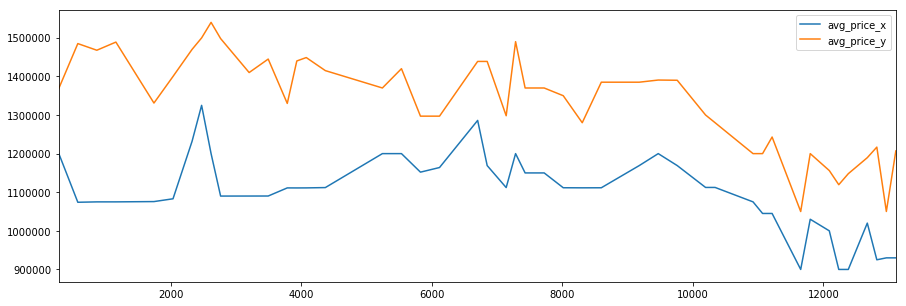

In [13]:
# Although the set of trades is small, they do seem to make a nice profit.  But before we get too excited
# about the margins, it is often wise to look at plots of price and volume data to get a better idea 
# whether a trade really has potential, or whether there may be unforseen difficulties pulling the trade
# off.  The graph below of the top tradeable type (15661) shows that, in fact, this type returns quite 
# well throughout the entire date range.
promising_h[promising_h.type_id == 33539][['avg_price_x', 'avg_price_y']].plot(figsize=[15,5])

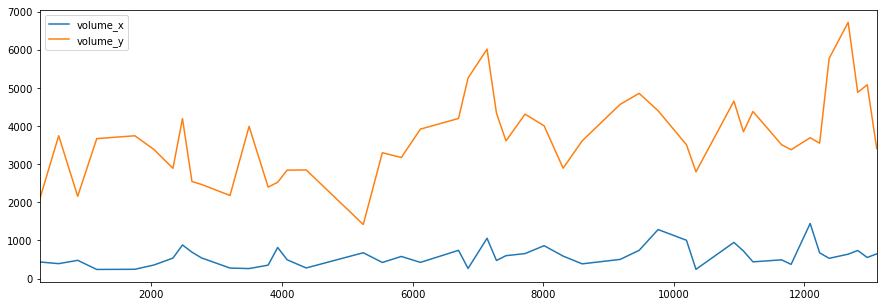

In [14]:
# Likewise, a volume graph of the same type shows that volume in Forge is robust.  We should expect
# to have little trouble selling transported goods.  Volume in Domain, on the other hand, is low
# but probably just high enough to pass the liquidity filter.  This means we may have to be patient
# with our buy orders.  It also suggests this won't be a high volume trade.  So while the margins
# will be good, the total profits may not be very high.
promising_h[promising_h.type_id == 33539][['volume_x', 'volume_y']].plot(figsize=[15,5])

In [15]:
# Now that we have the basics down, let's construct a function to discover all trading opportunities
# across all pairs of regions contained in the market history.  We've attempted to make this function
# reasonably self-contained so that it can be run standalone once you have created a liquidity
# filter and extracted market history.  This function DOES require the "liquid_types" function from 
# above.
#
import itertools
def find_opportunities(liquidp, history, profit_margin, min_prof_days, buy_cost_f=1.025, sell_cost_f=0.965, quantile=50):
    # Result will be sorted list of profitable trades, sorted by most profitable first
    opps = []
    sde_client = Client.SDE.get()
    # Use the same margin computer as before.
    def compute_margin(row):
        return (row.avg_price_y * sell_cost_f - row.avg_price_x * buy_cost_f)/row.avg_price_x
    # Capture regions and info
    region_set = set(history.region_id.unique())
    region_query = "{values:[" + ",".join(map(str, region_set)) + "]}"
    region_map = {}
    for i in Client.SDE.load_complete(sde_client.Map.getRegions, regionID=region_query):
        region_map[i['regionID']] = i
    # Find liquid types
    print("Finding liquid types...", end='')
    liquid_type_map = liquid_types(history, liquidp)
    type_map = {}
    def lazy_type_lookup(type_id):
        if type_id not in type_map.keys():
            info = sde_client.Inventory.getTypes(typeID="{values: [" + str(type_id) + "]}").result()[0][0]
            type_map[type_id] = info
        return type_map[type_id]
    print("done")
    # Iterate over pairs of regions, discovering most profitable trades
    for next_pair in itertools.permutations(region_set, 2):
        from_r = next_pair[0]
        to_r = next_pair[1]
        print("Checking for trades from %s to %s..." % (region_map[from_r]['regionName'], 
                                                        region_map[to_r]['regionName']), end='')
        # Find types liquid in both regions
        liquid_both = liquid_type_map[from_r].intersection(liquid_type_map[to_r])
        if len(liquid_both) == 0:
            # It's possible the set of liquid types does not overlap!
            print("done")
            continue
        # Construct merged data frame
        from_h = history[history.region_id == from_r]
        from_h = from_h[from_h.type_id.isin(liquid_both)]
        to_h = history[history.region_id == to_r]
        to_h = to_h[to_h.type_id.isin(liquid_both)]
        merged_h = pd.merge(from_h, to_h, on=['date', 'type_id'])
        # Select profitable trades
        promising_h = merged_h[(merged_h.avg_price_y * sell_cost_f - merged_h.avg_price_x * buy_cost_f)/ \
                               merged_h.avg_price_x >= profit_margin]
        # Filter for trades meeting day requirements
        tradeable = [x for x in promising_h.type_id.unique() if len(promising_h[promising_h.type_id == x]) >= min_prof_days]
        # Save the results.  Note that we select median margin here
        for next_type in tradeable:
            margin_metric = np.percentile(promising_h[promising_h.type_id == next_type].apply(compute_margin, axis=1), quantile)
            opps.append([lazy_type_lookup(next_type)['typeName'], 
                         next_type, 
                         region_map[from_r]['regionName'],
                         region_map[to_r]['regionName'], 
                         margin_metric])
        print("done")
    # Finally, return sorted results by maring
    return sorted(opps, key=itemgetter(4), reverse=True)

In [16]:
# Now we can try our trade finder on all regions.
opps = find_opportunities(liquidity_filter(min_values, min_volume_isk, min_volume, max_price),
                          market_history,
                          profit_margin, min_prof_days)

Finding liquid types...done
Checking for trades from Essence to Kor-Azor...done
Checking for trades from Essence to The Forge...done
Checking for trades from Essence to Sinq Laison...done
Checking for trades from Essence to Verge Vendor...done
Checking for trades from Essence to The Citadel...done
Checking for trades from Essence to Everyshore...done
Checking for trades from Essence to Derelik...done
Checking for trades from Essence to Devoid...done
Checking for trades from Essence to Metropolis...done
Checking for trades from Essence to Domain...done
Checking for trades from Essence to Lonetrek...done
Checking for trades from Essence to Tash-Murkon...done
Checking for trades from Essence to Kador...done
Checking for trades from Essence to Heimatar...done
Checking for trades from Kor-Azor to Essence...done
Checking for trades from Kor-Azor to The Forge...done
Checking for trades from Kor-Azor to Sinq Laison...done
Checking for trades from Kor-Azor to Verge Vendor...done
Checking for tr

In [17]:
# Let's see how this looks as a nice table.
print("%50s %10s %15s %15s %13s" % ("Asset Type", "Type ID", "From", "To", "Margin %"))
for next_row in opps:
    print("%50s %10d %15s %15s %10.2f%%" % (next_row[0], next_row[1], next_row[2], next_row[3], next_row[4] * 100))

                                        Asset Type    Type ID            From              To      Margin %
              Republic Fleet Commander Insignia II      15661          Domain       The Forge      25.37%
                        Sisters Core Scanner Probe      30488       The Forge        Heimatar      17.85%
                  Imperial Navy General Insignia I      15615     Sinq Laison       The Forge      17.59%
                        Sisters Core Scanner Probe      30488     Sinq Laison        Heimatar      16.84%
                 Imperial Navy General Insignia II      15669     Sinq Laison       The Forge      16.66%
                        Sisters Core Scanner Probe      30488      Metropolis        Heimatar      14.64%
                  Caldari Navy Antimatter Charge L      21740       The Forge          Domain      14.23%
                                          Veldspar       1230        Heimatar        Lonetrek      14.13%
                                          Ve

In [18]:
# As a first cut, this is a decent list.  The fact that Forge is the destination for most trades should
# surprise no one familiar with EVE.  Let's try another variant.  This time let's just consider weekends
# since we know liquidity changes for some types on weekends.  Let's also raise our profit margin to 10%.
# That's a nice profit margin that would make most traders happy.  The parameter changes are as follows:
#
# New date range with weekends only
weekends = [x for x in date_range if x.weekday() in (4, 5, 6)]
# Update min values for liquidity
min_values_weekends = len(weekends) - 2
# Update market history by resampling
weekend_history = market_history.ix[weekends]
# Finally, update profit margin and minimum profitable days.
# Note that we're keeping the same expectation of profitable days: we'd
# like at least half the days to be profitable.
pm_weekend = 0.10
min_prof_weekend = len(weekends)/2
opps_weekends = find_opportunities(liquidity_filter(min_values_weekends, min_volume_isk, min_volume, max_price),
                                   weekend_history, pm_weekend, min_prof_weekend)

Finding liquid types...done
Checking for trades from Essence to Sinq Laison...done
Checking for trades from Essence to The Forge...done
Checking for trades from Essence to The Citadel...done
Checking for trades from Essence to Verge Vendor...done
Checking for trades from Essence to Everyshore...done
Checking for trades from Essence to Derelik...done
Checking for trades from Essence to Devoid...done
Checking for trades from Essence to Kor-Azor...done
Checking for trades from Essence to Metropolis...done
Checking for trades from Essence to Domain...done
Checking for trades from Essence to Lonetrek...done
Checking for trades from Essence to Tash-Murkon...done
Checking for trades from Essence to Kador...done
Checking for trades from Essence to Heimatar...done
Checking for trades from Sinq Laison to Essence...done
Checking for trades from Sinq Laison to The Forge...done
Checking for trades from Sinq Laison to The Citadel...done
Checking for trades from Sinq Laison to Verge Vendor...done
Che

In [19]:
# Let's see how the weekend data looks
print("%50s %10s %15s %15s %13s" % ("Asset Type", "Type ID", "From", "To", "Margin %"))
for next_row in opps_weekends:
    print("%50s %10d %15s %15s %10.2f%%" % (next_row[0], next_row[1], next_row[2], next_row[3], next_row[4] * 100))

                                        Asset Type    Type ID            From              To      Margin %
                                           Kernite         20     Tash-Murkon       The Forge      26.04%
              Republic Fleet Commander Insignia II      15661          Domain       The Forge      25.38%
                                   Mining Drone II      10250       The Forge          Domain      21.45%
                           Inertial Stabilizers II       1405       The Forge     Sinq Laison      21.20%
                                           Kernite         20          Domain       The Forge      21.04%
                           Inertial Stabilizers II       1405          Domain     Sinq Laison      18.92%
                Caldari Navy Inferno Light Missile      27371       The Forge          Domain      18.39%
                  Imperial Navy General Insignia I      15615     Sinq Laison       The Forge      18.12%
                               Compressed Sc

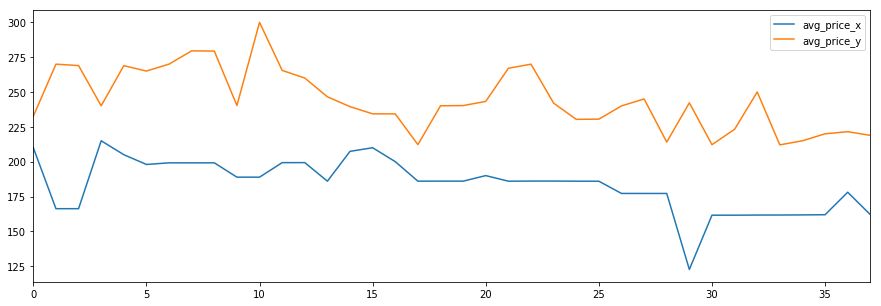

In [20]:
# Moving to weekends and a higher profit margin displaces some of the results from before.  Let's look at 
# price and volume trends for the top type (Kernite) in the specified regions.
#
tash_h = weekend_history[weekend_history.type_id == 20]
tash_h = tash_h[tash_h.region_id == 10000020]
forge_h = weekend_history[weekend_history.type_id == 20]
forge_h = forge_h[forge_h.region_id == 10000002]
tf_h = pd.merge(tash_h, forge_h, on=['date', 'type_id'])
tf_h[tf_h.type_id == 20][['avg_price_x', 'avg_price_y']].plot(figsize=[15,5])

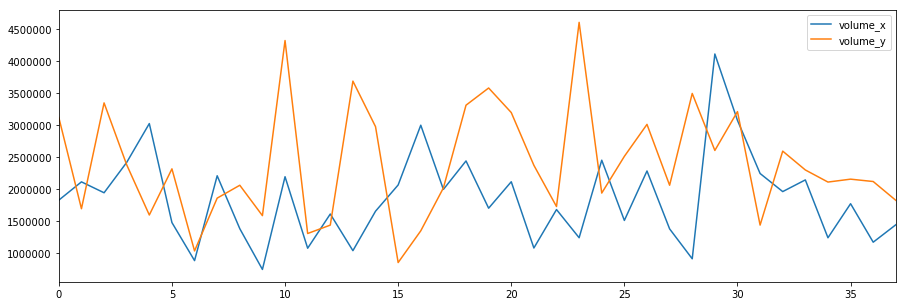

In [21]:
# We see that price separation is fairly robust throughout the historical range (just weekends in this case)
# Let's look at volume:
#
tf_h[tf_h.type_id == 20][['volume_x', 'volume_y']].plot(figsize=[15,5])

Volume is reasonably similar \(and robust\) in both regions, suggesting we should be able to buy and sell
without much difficulty.  This is likely a good trade to make if you're willing to haul.

In this example, we have focused on trades which have been historically strong and are on reasonably liquid 
assets.  Although there are many trade calculators for EVE, most do not apply a similar standard and simply
report which types are profitable to trade **now**.  Which strategy you use is entirely up to you of course.

While the analysis above provides convincing evidence for certain hauling routes, it leaves out a critical
aspect which is *risk*.  As seasoned EVE players know, hauling anything between stations incurs a non-zero
chance of getting attacked and losing everything.  A more complete analysis of hauling should include a 
study of risk and the likely effect on your profit.  That analsysis is beyond the scope of this example.
We cover risk in much more detail in a later chapter.